In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from matplotlib.patches import Rectangle
from scipy.io import loadmat
from fastai.vision.all import *
import re

In [2]:
!ls

cars_meta.mat			rnet50-lr_tuning.pkl
cars_test			temp1.mat
cars_test_annos_withlabels.mat	temp_cars_meta.mat
cars_train			temp_cars_test
cars_train_annos.mat		temp_cars_test_annos_withlabels.mat
models				temp_cars_train_annos.mat
read_data.ipynb			Untitled.ipynb


In [3]:
""" from google.cloud import storage

def download_blob(bucket_name, source_blob_name, destination_file_name):
    #Downloads a blob from the bucket
    # bucket_name = "your-bucket-name"
    # source_blob_name = "storage-object-name"
    # destination_file_name = "local/path/to/file"

    storage_client = storage.Client()

    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)

    print(
        "Blob {} downloaded to {}.".format(
            source_blob_name, destination_file_name
        )
    )
    """

' from google.cloud import storage\n\ndef download_blob(bucket_name, source_blob_name, destination_file_name):\n    #Downloads a blob from the bucket\n    # bucket_name = "your-bucket-name"\n    # source_blob_name = "storage-object-name"\n    # destination_file_name = "local/path/to/file"\n\n    storage_client = storage.Client()\n\n    bucket = storage_client.bucket(bucket_name)\n    blob = bucket.blob(source_blob_name)\n    blob.download_to_filename(destination_file_name)\n\n    print(\n        "Blob {} downloaded to {}.".format(\n            source_blob_name, destination_file_name\n        )\n    )\n    '

In [ ]:
#bucket_name = 'cars_stanford'
#mat_file_path = ['cars_meta.mat', 'cars_train_annos.mat','cars_test_annos_withlabels.mat']

In [ ]:
#temp = 'temp_'

In [ ]:
#for name in mat_file_path:
 #   source_blob_name = name 
  #  temp_mat_filename = temp+name
   # download_blob(bucket_name, source_blob_name, temp_mat_filename)

In [3]:
cars_meta = loadmat('temp_cars_meta.mat')
cars_train_annos = loadmat('temp_cars_train_annos.mat')
cars_test_annos = loadmat('temp_cars_test_annos_withlabels.mat')

In [4]:
labels = [c for c in cars_meta['class_names'][0]]
labels = pd.DataFrame(labels, columns=['labels'])
labels.head(10)

,labels
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012
5,Acura Integra Type R 2001
6,Acura ZDX Hatchback 2012
7,Aston Martin V8 Vantage Convertible 2012
8,Aston Martin V8 Vantage Coupe 2012
9,Aston Martin Virage Convertible 2012


In [5]:
# This is to download images
#bucket_name = 'cars_stanford'
#car_images = ['cars_test','cars_train']

In [6]:
"""def download_images(bucket_name, prefix,dl_dir):
    #bucket_name = 'your-bucket-name'
    #prefix = 'your-bucket-directory/'
    #dl_dir = 'your-local-directory/'
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)
    blobs = bucket.list_blobs(prefix=prefix)  # Get list of files
    for blob in blobs:
        filename = blob.name
        blob.download_to_filename(filename)  # Download
"""

"def download_images(bucket_name, prefix,dl_dir):\n    #bucket_name = 'your-bucket-name'\n    #prefix = 'your-bucket-directory/'\n    #dl_dir = 'your-local-directory/'\n    storage_client = storage.Client()\n    bucket = storage_client.get_bucket(bucket_name)\n    blobs = bucket.list_blobs(prefix=prefix)  # Get list of files\n    for blob in blobs:\n        filename = blob.name\n        blob.download_to_filename(filename)  # Download\n"

In [ ]:
#for prefix in car_images:
 #   download_images(bucket_name, prefix,prefix)

In [5]:
INPUT_train = Path("cars_train")
os.listdir(INPUT_train)
print(INPUT_train)
INPUT_train.ls()

cars_train


(#8144) [Path('cars_train/06110.jpg'),Path('cars_train/00352.jpg'),Path('cars_train/03804.jpg'),Path('cars_train/07882.jpg'),Path('cars_train/04186.jpg'),Path('cars_train/02968.jpg'),Path('cars_train/07663.jpg'),Path('cars_train/02321.jpg'),Path('cars_train/00709.jpg'),Path('cars_train/06574.jpg')...]

In [6]:
INPUT_test = Path("cars_test")
os.listdir(INPUT_test)
print(INPUT_test)
INPUT_test.ls()

cars_test


(#8042) [Path('cars_test/06110.jpg'),Path('cars_test/00352.jpg'),Path('cars_test/03804.jpg'),Path('cars_test/07882.jpg'),Path('cars_test/04186.jpg'),Path('cars_test/02968.jpg'),Path('cars_test/07663.jpg'),Path('cars_test/02321.jpg'),Path('cars_test/00709.jpg'),Path('cars_test/06574.jpg')...]

#### Training data

In [7]:
frame = [[i.flat[0] for i in line] for line in cars_train_annos['annotations'][0]]
columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class', 'fname']
df_train = pd.DataFrame(frame, columns=columns)
df_train['class'] = df_train['class']-1 # Python indexing starts on zero.
df_train['fname'] = [f for f in df_train['fname']] #  Appending Path
df_train.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname
0,39,116,569,375,13,00001.jpg
1,36,116,868,587,2,00002.jpg
2,85,109,601,381,90,00003.jpg
3,621,393,1484,1096,133,00004.jpg
4,14,36,133,99,105,00005.jpg


In [8]:
df_train = df_train.merge(labels, left_on='class', right_index=True)
df_train = df_train.sort_index()
df_train['labels'] = df_train.labels.astype('category')
df_train.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname,labels
0,39,116,569,375,13,00001.jpg,Audi TTS Coupe 2012
1,36,116,868,587,2,00002.jpg,Acura TL Sedan 2012
2,85,109,601,381,90,00003.jpg,Dodge Dakota Club Cab 2007
3,621,393,1484,1096,133,00004.jpg,Hyundai Sonata Hybrid Sedan 2012
4,14,36,133,99,105,00005.jpg,Ford F-450 Super Duty Crew Cab 2012


#### Test data

In [9]:
frame = [[i.flat[0] for i in line] for line in cars_test_annos['annotations'][0]]
columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2','class', 'fname']
df_test = pd.DataFrame(frame, columns=columns)
df_test['class'] = df_test['class']-1 # Python indexing starts on zero.
df_test['fname'] = [f for f in df_test['fname']] # Appending Path
df_test.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname
0,30,52,246,147,180,00001.jpg
1,100,19,576,203,102,00002.jpg
2,51,105,968,659,144,00003.jpg
3,67,84,581,407,186,00004.jpg
4,140,151,593,339,184,00005.jpg


In [10]:
df_test = df_test.merge(labels, left_on='class', right_index=True)
df_test = df_test.sort_index()
df_test['labels'] = df_test.labels.astype('category')
df_test.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname,labels
0,30,52,246,147,180,00001.jpg,Suzuki Aerio Sedan 2007
1,100,19,576,203,102,00002.jpg,Ferrari 458 Italia Convertible 2012
2,51,105,968,659,144,00003.jpg,Jeep Patriot SUV 2012
3,67,84,581,407,186,00004.jpg,Toyota Camry Sedan 2012
4,140,151,593,339,184,00005.jpg,Tesla Model S Sedan 2012


In [11]:
#df_train.info()

In [12]:
#df_test.info()

#### Combining train and test data in one dataframe. For this project we will train on train data and use the test data as validation set.

In [13]:
df1 = df_train
df1["is_valid"] = False
df2 = df_test
df2["is_valid"] = True
all_df = pd.concat([df1,df2]).reset_index()
df_train = df1
df_test = df2

In [14]:
all_df.tail()

,index,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname,labels,is_valid
16180,8036,49,57,1169,669,62,08037.jpg,Chevrolet Sonic Sedan 2012,True
16181,8037,23,18,640,459,15,08038.jpg,Audi V8 Sedan 1994,True
16182,8038,33,27,602,252,16,08039.jpg,Audi 100 Sedan 1994,True
16183,8039,33,142,521,376,37,08040.jpg,BMW Z4 Convertible 2012,True
16184,8040,77,73,506,380,31,08041.jpg,BMW X5 SUV 2007,True


In [15]:
all_df['is_valid'][16144]

True

#### We create a Datablock object

In [16]:
dblock = DataBlock()
dsets = dblock.datasets(df1)
len(dsets.train),len(dsets.valid)

(6516, 1628)

#### This is randomly splitting, so use a spliiter function that tells which files are test and which files are valid based on 'is_valid' column
- Need to look at either cars_test folder or cars_train folder depending on the value in 'is_valid'

In [17]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

def get_x(df): 
    if df['is_valid']==False:
        return INPUT_train/df['fname']
    if df['is_valid']==True:
        return INPUT_test/df['fname']    
    
#def get_y(r): return (''.join(r['labels'].split(' ')))

def get_y(r): return r['labels']

In [18]:
dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                   splitter=splitter,
                   #splitter=RandomSplitter(seed=42),
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = Resize(299),
                   batch_tfms=[aug_transforms(do_flip=False, flip_vert=True, max_rotate=5.0, max_zoom=1.1, max_lighting=0.2, 
                                               max_warp=0.2, p_affine=0.75, p_lighting=0.75),Normalize.from_stats(*imagenet_stats)]
                  )
dsets = dblock.datasets(all_df)

In [19]:
#len(dsets.train),len(dsets.valid)

In [20]:
#dsets.valid[0]

In [21]:
#dsets.train[0]

In [22]:
dsets.vocab

(#196) ['AM General Hummer SUV 2000','Acura Integra Type R 2001','Acura RL Sedan 2012','Acura TL Sedan 2012','Acura TL Type-S 2008','Acura TSX Sedan 2012','Acura ZDX Hatchback 2012','Aston Martin V8 Vantage Convertible 2012','Aston Martin V8 Vantage Coupe 2012','Aston Martin Virage Convertible 2012'...]

In [23]:
dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                   splitter=splitter,
                   #splitter=RandomSplitter(seed=42),
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = Resize(299),
                   batch_tfms=[*aug_transforms(do_flip=False, flip_vert=True, max_rotate=5.0, max_zoom=1.1, max_lighting=0.2, 
                                               max_warp=0.2, p_affine=0.75, p_lighting=0.75), Normalize.from_stats(*imagenet_stats)]
                  )
dls = dblock.dataloaders(all_df,bs=32)

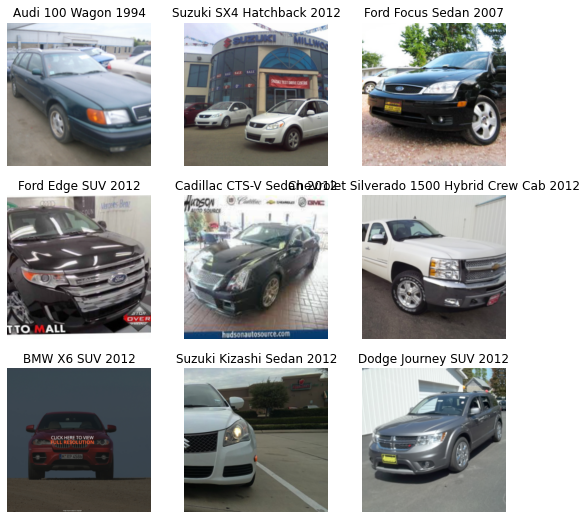

In [24]:
dls.show_batch()

In [25]:
learn = cnn_learner(dls, resnet50)

In [26]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([32, 196])

In [27]:
y.size()

torch.Size([32])

#### Baseline

In [28]:
%time learn = cnn_learner(dls, resnet50, metrics=accuracy)
%time learn.fine_tune(2)

CPU times: user 568 ms, sys: 180 ms, total: 748 ms
Wall time: 683 ms


epoch,train_loss,valid_loss,accuracy,time
0,4.604191,3.320934,0.245119,02:57


epoch,train_loss,valid_loss,accuracy,time
0,2.612473,1.660517,0.573560,03:41
1,1.336244,1.054817,0.728019,03:41


CPU times: user 6min 35s, sys: 2min 59s, total: 9min 34s
Wall time: 10min 20s


In [35]:
learn.validate()

(#2) [1.0652754306793213,0.7336152195930481]

#### Learing rate finder

In [33]:
%time learn = cnn_learner(dls, resnet50, metrics=accuracy)
%time learn.fine_tune(1, base_lr = 0.1)

CPU times: user 660 ms, sys: 176 ms, total: 836 ms
Wall time: 754 ms


epoch,train_loss,valid_loss,accuracy,time
0,8.461578,11.043348,0.007710,02:57


epoch,train_loss,valid_loss,accuracy,time
0,5.729819,610.406189,0.006840,03:35


CPU times: user 4min 4s, sys: 1min 45s, total: 5min 50s
Wall time: 6min 33s


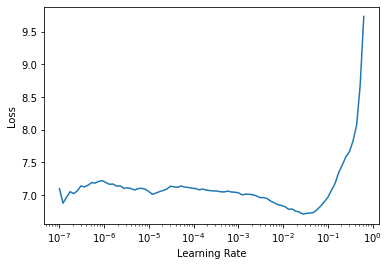

In [29]:
learn = cnn_learner(dls, resnet50, metrics=accuracy)
lr_min,lr_steep = learn.lr_find()

In [30]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 2.75e-03, steepest point: 1.00e-05


In [82]:
learn = cnn_learner(dls, resnet50, metrics=accuracy)
learn.fine_tune(2, base_lr = 2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.431587,3.776641,0.191646,01:10


epoch,train_loss,valid_loss,accuracy,time
0,3.292622,2.410288,0.414619,01:30
1,2.150403,1.907703,0.525184,01:30


In [31]:
learn = cnn_learner(dls, resnet50, metrics=accuracy)
learn.fit_one_cycle(3, base_lr = 2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.614041,3.094066,0.280065,02:55
1,2.718300,1.829314,0.547693,02:53
2,1.952403,1.635034,0.589106,02:53


In [32]:
learn.unfreeze()

SuggestedLRs(lr_min=1.584893179824576e-05, lr_steep=6.309573450380412e-07)

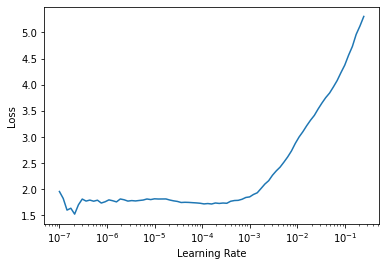

In [33]:
learn.lr_find()

In [34]:
learn.fit_one_cycle(10, lr_max=slice(1e-5,2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.791961,1.431250,0.637234,03:42
1,1.810441,1.472441,0.608631,03:40
2,1.463595,1.057598,0.709116,03:40
3,1.077181,0.935391,0.739833,03:40
4,0.751771,0.716506,0.806367,03:40
5,0.486766,0.589472,0.841686,03:40
6,0.308329,0.537949,0.855117,03:41
7,0.180649,0.479633,0.875264,03:40
8,0.122592,0.447563,0.879990,03:40
9,0.086395,0.443805,0.884591,03:41


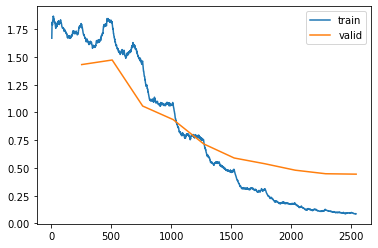

In [35]:
learn.recorder.plot_loss()

In [36]:
learn.save('rnet50-lr_tuning')

Path('models/rnet50-lr_tuning.pth')

In [37]:
learn.load('rnet50-lr_tuning')

In [38]:
test_dl = dls.test_dl(df_test,with_labels=True)

In [39]:
#learn.get_preds(dl=test_dl)
#preds = learn.get_preds(dl=test_dl)
learn.validate(dl=test_dl)

(#2) [0.443805456161499,0.8845914602279663]

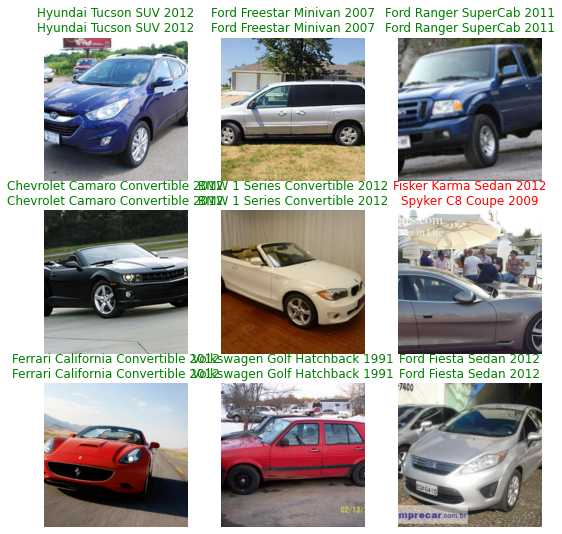

In [40]:
learn.show_results()

In [ ]:
interp = Interpretation.from_learner(learn)

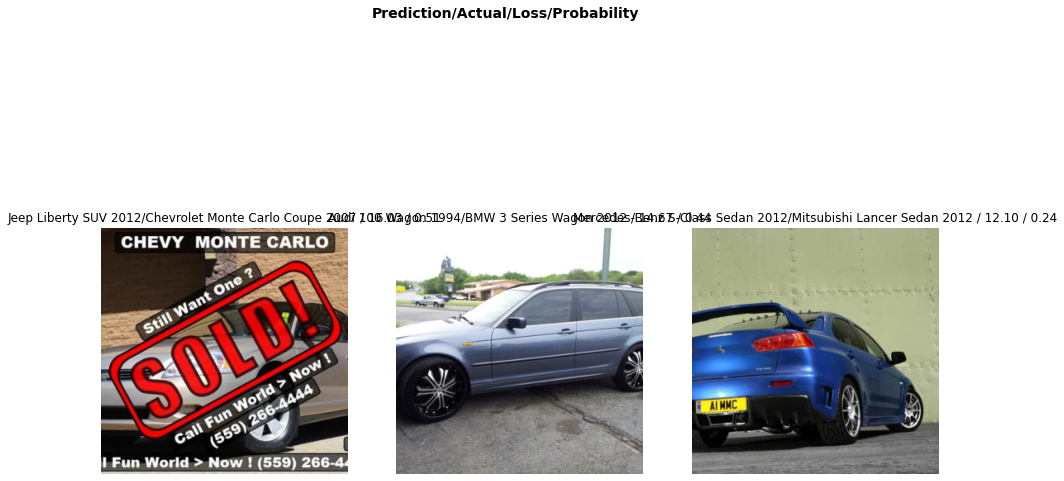

In [171]:
interp.plot_top_losses(3, figsize=(15,10))

In [137]:
accuracy(preds[0], preds[1])

tensor(0.9559)

In [159]:
learn1 = load_learner('rnet50-lr_tuning.pkl',test=test_dl)

TypeError: load_learner() got an unexpected keyword argument 'test'

In [166]:
#preds = learn1.get_preds(dl=test_dl)
#learn1.validate(dl=test_dl)

In [131]:
df_train.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname,labels,is_valid
0,39,116,569,375,13,00001.jpg,Audi TTS Coupe 2012,False
1,36,116,868,587,2,00002.jpg,Acura TL Sedan 2012,False
2,85,109,601,381,90,00003.jpg,Dodge Dakota Club Cab 2007,False
3,621,393,1484,1096,133,00004.jpg,Hyundai Sonata Hybrid Sedan 2012,False
4,14,36,133,99,105,00005.jpg,Ford F-450 Super Duty Crew Cab 2012,False


In [167]:
df_test.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname,labels,is_valid
0,30,52,246,147,181,00001.jpg,Suzuki Kizashi Sedan 2012,True
1,100,19,576,203,103,00002.jpg,Ferrari 458 Italia Coupe 2012,True
2,51,105,968,659,145,00003.jpg,Jeep Wrangler SUV 2012,True
3,67,84,581,407,187,00004.jpg,Toyota Corolla Sedan 2012,True
4,140,151,593,339,185,00005.jpg,Toyota Sequoia SUV 2012,True


In [208]:
tts= df_test[['class','labels']]

In [209]:
tts.head()

,class,labels
0,181,Suzuki Kizashi Sedan 2012
1,103,Ferrari 458 Italia Coupe 2012
2,145,Jeep Wrangler SUV 2012
3,187,Toyota Corolla Sedan 2012
4,185,Toyota Sequoia SUV 2012


In [211]:
ttt= df_train[['class','labels']]

In [215]:
ttt.sort_values('class')

,class,labels
6173,0,AM General Hummer SUV 2000
5920,0,AM General Hummer SUV 2000
3392,0,AM General Hummer SUV 2000
4543,0,AM General Hummer SUV 2000
945,0,AM General Hummer SUV 2000
...,...,...
7894,195,smart fortwo Convertible 2012
6003,195,smart fortwo Convertible 2012
2102,195,smart fortwo Convertible 2012
2391,195,smart fortwo Convertible 2012


In [216]:
tts.sort_values('class')

,class,labels
6173,0,AM General Hummer SUV 2000
5920,0,AM General Hummer SUV 2000
3392,0,AM General Hummer SUV 2000
4543,0,AM General Hummer SUV 2000
945,0,AM General Hummer SUV 2000
...,...,...
7894,195,smart fortwo Convertible 2012
6003,195,smart fortwo Convertible 2012
2102,195,smart fortwo Convertible 2012
2391,195,smart fortwo Convertible 2012
